In [1]:
import os

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import FeatureHasher, HashingVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Input, Concatenate, Dropout, Flatten, \
    BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from preprocess_functions import clean_text, lemmatize_text, pos_tagging, remove_stopwords, extract_structural_features, \
    replace_text_components, extract_url_features, replace_url_components

# Input data files are available in the read-only "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dir_name, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dir_name, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All".
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside the current session


/kaggle/input/tweets-dataset-for-cyberattack-detection/tweets_final.csv


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
#!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
#!unzip -o /usr/share/nltk_data/corpora/stopwords.zip -d /usr/share/nltk_data/corpora/


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [12]:
# Load data from CSV file
DATA = pd.read_csv('/kaggle/input/tweets-dataset-for-cyberattack-detection/tweets_final.csv')

# Data Preprocessing
# Data Cleaning
DATA['text'] = DATA['text'].apply(clean_text)

# Lemmatization
DATA['text'] = DATA['text'].apply(lemmatize_text)

# POS Tagging
DATA['pos_tags'] = DATA['text'].apply(pos_tagging)

# Tokenization
TOKENIZER = Tokenizer()
TOKENIZER.fit_on_texts(DATA['text'])
X_SEQ = TOKENIZER.texts_to_sequences(DATA['text'])
X_PAD = pad_sequences(X_SEQ, maxlen=100)

# Stopwords removal
DATA['text'] = DATA['text'].apply(remove_stopwords)

# Apply the function to extract structural features and create a new column
DATA['structural_features'] = DATA['text'].apply(extract_structural_features)

# Define the function to replace specific text components with predefined tokens
DATA['text'] = DATA['text'].apply(replace_text_components)

# Apply the function to the 'destination_url' column and create new columns for each feature
URL_FEATURES = DATA.apply(
    lambda row: pd.Series(extract_url_features(row['destination_url'], row['urls'])),
    axis=1
)
# Combine all details into a single DataFrame
URL_FEATURES.columns = [
    'url_length',
    'has_security_protocol',
    'is_shortened_url',
    'strings_divided_by_periods',
    'strings_divided_by_hyphens',
    'strings_divided_by_slashes',
    'num_words',
    'num_ips',
    'num_digits',
    'num_hyphens',
    'num_periods',
    'num_slashes',
    'num_uppercase',
    'num_lowercase',
    'num_ampersand_symbols',
    'num_equal_symbols',
    'num_question_marks',
    'num_wave_symbols',
    'num_plus_signs',
    'num_colon_symbols',
    'num_other_characters',
    'has_extension',
    'domain_suffix',
    'registrant'
]
DATA = pd.concat([DATA, URL_FEATURES], axis=1)
URL_FEATURES = DATA.apply(
    lambda row: pd.Series(extract_url_features(row['destination_url'], row['urls'])),
    axis=1
)
URL_FEATURES_DF = pd.DataFrame(
    URL_FEATURES.values,
    columns=['feature_{}'.format(i) for i in range(URL_FEATURES.shape[1])]
)

# Replace NaN values with an empty string in the 'destination_url' column
DATA['destination_url'] = DATA['destination_url'].fillna('')
DATA['resolved_urls'] = DATA['destination_url'].apply(replace_url_components)

DATA.head()


/tmp/ipykernel_23/3622854706.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  DATA['destination_url'].fillna('', inplace=True)


,_id,date,id,relevant,text,tweet,type,watson,annotation,urls,...,num_equal_symbols,num_question_marks,num_wave_symbols,num_plus_signs,num_colon_symbols,num_other_characters,has_extension,domain_suffix,registrant,resolved_urls
0,b'5b88752abb325e65390af240',2018-08-30 22:52:25+00:00,1035299228984041472,False,Best way build empathy honesty vulnerability,{'created_at': 'Thu Aug 30 22:52:25 +0000 2018...,vulnerability,"{'usage': {'text_units': 1, 'text_characters':...",irrelevant,[],...,NA,NA,NA,NA,NA,NA,NA,NA,NA,
1,b'5b8875d5bb325e65a22cf81b',2018-08-30 22:55:15+00:00,1035299941932036096,False,Cryptocurrency Scams Replacing Ransomware Atta...,{'created_at': 'Thu Aug 30 22:55:15 +0000 2018...,ransomware,"{'usage': {'text_units': 1, 'text_characters':...",business,['https://ubm.io/2MCQwfg'],...,0,0,0,0,1,0,Y,com/endpoint-security,darkreading,https://www.darkreading.com/endpoint-security
2,b'5b88768dbb325e65fa7e78e3',2018-08-30 22:58:20+00:00,1035300715470757889,False,Cryptocurrency Scams Replacing Ransomware Atta...,{'created_at': 'Thu Aug 30 22:58:20 +0000 2018...,ransomware,"{'usage': {'text_units': 1, 'text_characters':...",business,['http://quantus.biz/security/2018/08/30/crypt...,...,0,0,0,0,1,0,Y,group/,quantusintel,http://www.quantusintel.group/
3,b'5b8876f9bb325e65fa7e78e4',2018-08-30 23:00:08+00:00,1035301167952211969,True,Protect customer access Prestashop Anti DDoS A...,{'created_at': 'Thu Aug 30 23:00:08 +0000 2018...,ddos,"{'usage': {'text_units': 1, 'text_characters':...",threat,['http://addons.prestashop.com/en/23513-anti-d...,...,0,0,0,0,1,0,Y,html,prestashop,https://addons.prestashop.com/en/23513-anti-dd...
4,b'5b8876f9bb325e65fa7e78e5',2018-08-30 23:00:09+00:00,1035301173178249217,True,Data leak Huazhu Hotels may affect 130 million...,{'created_at': 'Thu Aug 30 23:00:09 +0000 2018...,leak,"{'usage': {'text_units': 1, 'text_characters':...",threat,['http://www.hotelmanagement.net/tech/data-lea...,...,0,0,0,0,1,0,Y,net/tech/data-leak-from-huazhu-hotels-may-affe...,hotelmanagement,http://www.hotelmanagement.net/tech/data-leak-...


In [13]:
# Vectorization
# Hashing Vector for content
HASHING_VECTORIZER = HashingVectorizer(n_features=100)
X_HASH = HASHING_VECTORIZER.fit_transform(DATA['text'])

# Text Structure Vector
X_TEXT_STRUCTURE = np.array(DATA['structural_features'].tolist())

URL_FEATURES_LISTS = URL_FEATURES_DF.astype(str).apply(lambda row: row.tolist(), axis=1)

# Hash the combined features
HASHER = FeatureHasher(n_features=1000, input_type='string')
X_URL_STRUCTURE_HASHED = HASHER.transform(URL_FEATURES_LISTS)

# Convert hashed features to array
X_URL_STRUCTURE_HASHED = X_URL_STRUCTURE_HASHED.toarray()

# Convert labels to numerical values
LABEL_DICT = {False: 0, True: 1}
Y = np.array([LABEL_DICT[category] for category in DATA['relevant']])

# Split the dataset into training and testing sets
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(
    np.array(X_PAD), Y,
    test_size=.2,
    random_state=42
)

X_TRAIN_HASH, X_TEST_HASH = train_test_split(
    X_HASH,
    test_size=.2,
    random_state=42
)

X_TRAIN_TEXT_STRUCTURE, X_TEST_TEXT_STRUCTURE = train_test_split(
    X_TEXT_STRUCTURE,
    test_size=.2,
    random_state=42
)

X_TRAIN_URL_STRUCTURE, X_TEST_URL_STRUCTURE = train_test_split(
    X_URL_STRUCTURE_HASHED,
    test_size=.2,
    random_state=42
)


In [ ]:
def build_cnn(input_dim, output_dim):
    input_content = Input(shape=(100,), name='content_input')
    input_text_structure = Input(shape=(16,), name='text_structure_input')
    input_url_structure = Input(shape=(1000,), name='url_structure_input')

    # Additional input layers for other features
    embedding = Embedding(
        input_dim=input_dim,
        output_dim=100,
        input_length=100
    )(input_content)
    conv_layer = Conv1D(64, 5, activation='relu')(embedding)
    conv_layer = BatchNormalization()(conv_layer)
    dropout_layer = Dropout(rate=.7)(conv_layer)
    pooling_layer = GlobalMaxPooling1D()(dropout_layer)
    flattened_layer = Flatten()(pooling_layer)

    # Concatenate all input layers
    concatenated_inputs = Concatenate()([
        flattened_layer,
        input_text_structure,
        input_url_structure
    ])

    # Fully connected layers
    dense1 = Dense(64, activation='relu')(concatenated_inputs)
    dropout_dense = Dropout(rate=.5)(dense1)
    output = Dense(output_dim, activation='softmax')(dropout_dense)

    # Define the model
    model = Model(
        inputs=[input_content, input_text_structure, input_url_structure],
        outputs=output
    )
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

In [14]:
EARLY_STOPPING = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

LR_SCHEDULER = ReduceLROnPlateau(
    monitor='val_loss',
    factor=.5,
    patience=5,
    min_lr=1e-6
)

# Number of folds for cross-validation
K = 5
SKF = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

# Variables to track performance
VAL_ACCURACIES = []

# Perform k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(SKF.split(X_TRAIN, Y_TRAIN)):
    X_TRAIN_FOLD = X_TRAIN[train_idx]
    X_TRAIN_TEXT_STRUCTURE_FOLD = X_TRAIN_TEXT_STRUCTURE[train_idx]
    X_TRAIN_URL_STRUCTURE_FOLD = X_TRAIN_URL_STRUCTURE[train_idx]
    Y_TRAIN_FOLD = Y_TRAIN[train_idx]

    X_VAL_FOLD = X_TRAIN[val_idx]
    X_VAL_TEXT_STRUCTURE_FOLD = X_TRAIN_TEXT_STRUCTURE[val_idx]
    X_VAL_URL_STRUCTURE_FOLD = X_TRAIN_URL_STRUCTURE[val_idx]
    Y_VAL_FOLD = Y_TRAIN[val_idx]

    # Build the CNN model for each fold
    MODEL = build_cnn(input_dim=len(TOKENIZER.word_index) + 1, output_dim=2)

    # Train the model for this fold
    MODEL.fit(
        x=[X_TRAIN_FOLD, X_TRAIN_TEXT_STRUCTURE_FOLD, X_TRAIN_URL_STRUCTURE_FOLD],
        y=Y_TRAIN_FOLD,
        batch_size=32,
        epochs=1000,
        validation_data=(
            [X_VAL_FOLD, X_VAL_TEXT_STRUCTURE_FOLD, X_VAL_URL_STRUCTURE_FOLD],
            Y_VAL_FOLD
        ),
        callbacks=[EARLY_STOPPING, LR_SCHEDULER]
    )

    # Evaluate the model on validation set and store accuracy
    VAL_ACCURACY = MODEL.evaluate(
        [X_VAL_FOLD, X_VAL_TEXT_STRUCTURE_FOLD, X_VAL_URL_STRUCTURE_FOLD],
        Y_VAL_FOLD,
        verbose=0
    )[1]
    print(f'Validation Accuracy for Fold {fold + 1}:\t{VAL_ACCURACY * 100:.2f}%')

    VAL_ACCURACIES.append(VAL_ACCURACY)

# Calculate the mean and standard deviation of the validation accuracies
MEAN_VAL_ACCURACY = np.mean(VAL_ACCURACIES)
STD_VAL_ACCURACY = np.std(VAL_ACCURACIES)

print(f"\nMean Validation Accuracy: {MEAN_VAL_ACCURACY * 100:.2f}%")
print(f"Standard Deviation of Validation Accuracy: {STD_VAL_ACCURACY * 100:.2f}%")


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/1000


I0000 00:00:1733353521.140181      95 service.cc:145] XLA service 0x7e2c54005430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733353521.140230      95 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733353521.140234      95 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 54/428 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4966 - loss: 2.4574

I0000 00:00:1733353525.547799      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


428/428 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.6321 - loss: 1.0814 - val_accuracy: 0.6455 - val_loss: 0.6159 - learning_rate: 0.0010
Epoch 2/1000
428/428 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8304 - loss: 0.3850 - val_accuracy: 0.7874 - val_loss: 0.4549 - learning_rate: 0.0010
Epoch 3/1000
428/428 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8926 - loss: 0.2696 - val_accuracy: 0.7631 - val_loss: 0.4867 - learning_rate: 0.0010
Epoch 4/1000
428/428 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9331 - loss: 0.1810 - val_accuracy: 0.7605 - val_loss: 0.5303 - learning_rate: 0.0010
Epoch 5/1000
428/428 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9664 - loss: 0.0976 - val_accuracy: 0.7558 - val_loss: 0.5426 - learning_rate: 0.0010
Epoch 6/1000
428/428 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9795 - loss: 0.0608 - val_accuracy: 0.7564 - val_loss: 0.6990 - learning_rate: 0.0010
Epoch 7/1000
428/428 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9883 - loss: 0.0350

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6285 - loss: 0.6496
Test Loss: 0.6359938979148865	Test Accuracy: 0.6350023150444031
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


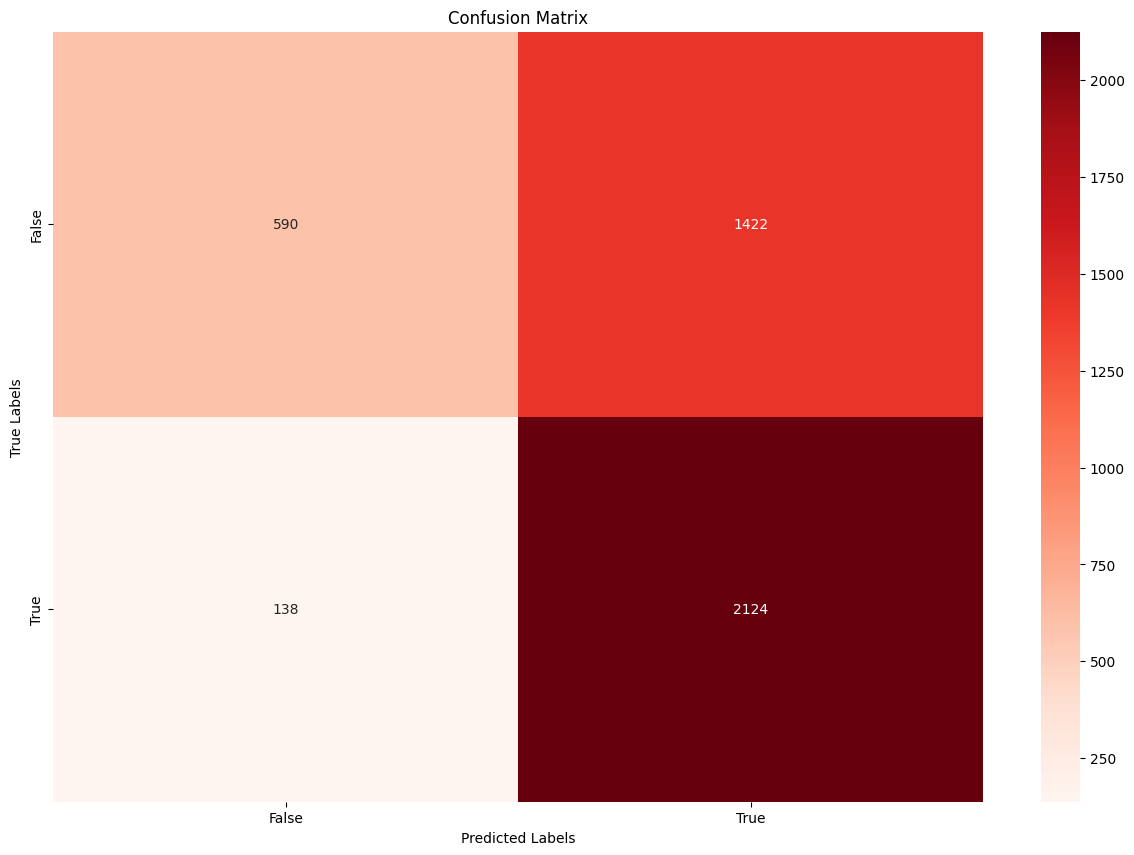

In [15]:
MODEL = None
# Evaluate the model
LOSS, ACCURACY = MODEL.evaluate(
    [X_TEST, X_TEST_TEXT_STRUCTURE, X_TEST_URL_STRUCTURE],
    Y_TEST
)
print(f'Test Loss: {LOSS}\tTest Accuracy: {ACCURACY}')

# Make predictions on the test set
PREDICTIONS = MODEL.predict(
    [X_TEST, X_TEST_TEXT_STRUCTURE, X_TEST_URL_STRUCTURE]
)
PREDICTED_LABELS = np.argmax(PREDICTIONS, axis=1)

# Compute confusion matrix
CONF_MATRIX = confusion_matrix(Y_TEST, PREDICTED_LABELS)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(
    CONF_MATRIX,
    annot=True,
    fmt='d',
    cmap='Reds',
    xticklabels=LABEL_DICT.keys(),
    yticklabels=LABEL_DICT.keys()
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
